# ERA5 reanalysis on single levels on Earth Data Hub

***
This notebook will provide you guidance on how to access and use the reanalysis-era5-single-levels.zarr datset on Earth Data Hub.

The first goal is to compute the 2 metre temperature (t2m) anomaly for the month of October 2023, in the Germany area, against the 1981-2010 reference period. 

The second goal is to compute the t2m climatology (monthly means and standard deviations) in Berlin for the same reference period and compare it with the monthly averages of 2023.
***

### Key steps in this notebook:

1. import the necessary dependencies
2. declare workflow parameters
4. preview the data
5. select and reduce the data
6. plot the results

### Import dependences

In [15]:
import display
import matplotlib.pyplot as plt
import xarray as xr

### Declare workflow parameters

In [16]:
AREA = {"latitude": slice(55, 47), "longitude": slice(5, 16)}
DATASET = "s3://ecmwf-era5-single-levels/reanalysis-era5-single-levels.zarr"
LOCATION = {"latitude": 52.5, "longitude": 13.4}
REFERENCE_PERIOD = slice("1981", "2010")
MONTH = "2023-10"

***
The typical structure of a workflow that uses EDH data looks like this:
1. data preview
2. data selection
3. data reduction
4. plot

While allowing the user to preview the data and plan the operations to perform on it, these steps reduce the amount of data that will be actually downloaded and processed when the computation is triggered.
***

#### 1. Data preview
Xarray and Dask work together following a lazy principle. This means operations are not performed when called, but rather when actually needed. For instance, the computation is triggered when the `.compute()` or `.plot()` methods are called. 

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:


In [17]:
ds = xr.open_dataset(DATASET, chunks={}, engine="zarr").astype("float32")
ds

<xarray.Dataset>
Dimensions:     (valid_time: 735600, latitude: 721, longitude: 1440)
Coordinates:
  * latitude    (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude   (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1940-01-01 ... 2023-11-30T23:00:00
Data variables:
    d2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    t2m         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    tp          (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 dask.array<chunksize=(2880, 64, 64), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2023-11-29T17:46 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

#### 2. Data selection

To reduce the amount of data xarray will download we perform a geographical selection corresponding to the Germany AREA. We also convert the temperature to °C:

In [18]:
t2m = ds.t2m - 273.15
t2m.attrs["units"] = "C"
t2m_area = t2m.sel(**AREA)
t2m_area

<xarray.DataArray 't2m' (valid_time: 735600, latitude: 33, longitude: 45)>
dask.array<getitem, shape=(735600, 33, 45), dtype=float32, chunksize=(2880, 33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude   (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 1940-01-01 ... 2023-11-30T23:00:00
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    last_restart_dim_updated:                 735600
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    C

### Average October 2023 2 metre temperature in Germany

We further select October 2023 from the dataset above

In [19]:
t2m_area_month = t2m_area.sel(valid_time="2023-10")
t2m_area_month

<xarray.DataArray 't2m' (valid_time: 744, latitude: 33, longitude: 45)>
dask.array<getitem, shape=(744, 33, 45), dtype=float32, chunksize=(480, 33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude    (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude   (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number      int64 ...
    surface     float64 ...
  * valid_time  (valid_time) datetime64[ns] 2023-10-01 ... 2023-10-31T23:00:00
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    last_restart_dim_updated:                 735600
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    C

#### 3. Data reduction

We can then compute the monthly mean, effectively reducing the data to a bi-dimensional shape:

In [20]:
t2m_area_month_mean = t2m_area_month.mean(dim="valid_time")
t2m_area_month_mean

<xarray.DataArray 't2m' (latitude: 33, longitude: 45)>
dask.array<mean_agg-aggregate, shape=(33, 45), dtype=float32, chunksize=(33, 44), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude  (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number     int64 ...
    surface    float64 ...
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    last_restart_dim_updated:                 735600
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    C

***
! Remember, the computation is truly performed only when the `.compute()` method is called
***


In [21]:
%%time
%%capture

t2m_area_month_mean = t2m_area_month_mean.compute()

CPU times: user 414 ms, sys: 55.8 ms, total: 470 ms
Wall time: 660 ms


#### 4. Plot
Finally, we can plot the results on a map:

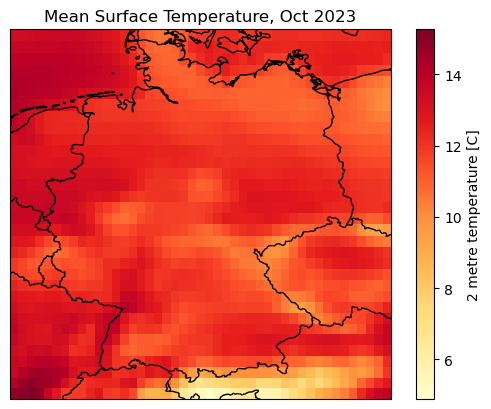

In [22]:
display.map(t2m_area_month_mean, vmax=None, cmap="YlOrRd", title="Mean Surface Temperature, Oct 2023")

### October 2023 anomaly vs 1981-2010 reference period

Following the above schema of first selecting and then reducing the data, we can easily compute the average October 2 metre temperature for the selected reference period.

Again, we only consider the Germany area.

In [23]:
%%time

t2m_area_month_mean_ref = t2m_area.sel(valid_time=t2m_area["valid_time.month"] == 10).sel(valid_time=REFERENCE_PERIOD).mean(dim="valid_time").compute()
t2m_area_month_mean_ref

CPU times: user 8.68 s, sys: 2.12 s, total: 10.8 s
Wall time: 6.88 s


<xarray.DataArray 't2m' (latitude: 33, longitude: 45)>
array([[12.118893 , 12.150612 , 12.182521 , ..., 10.92363  , 10.913224 ,
        10.906762 ],
       [12.293988 , 12.33104  , 12.340167 , ..., 10.999492 , 10.970863 ,
        10.961813 ],
       [12.442182 , 12.478202 , 12.473453 , ..., 10.931011 , 10.881705 ,
        10.6380825],
       ...,
       [10.711722 , 11.187962 , 11.414841 , ...,  6.387398 ,  6.9745984,
         8.088368 ],
       [11.210116 , 11.697665 , 11.931375 , ...,  8.019686 ,  8.610436 ,
         8.931069 ],
       [11.791435 , 12.042852 , 12.168812 , ...,  9.398028 ,  9.952363 ,
        10.022939 ]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude  (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number     int64 0
    surface    float64 0.0
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    last_restart_dim_updated:                 735600
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    C

The anomaly computation is then straightforward:

In [24]:
anomaly = t2m_area_month_mean - t2m_area_month_mean_ref
anomaly

<xarray.DataArray 't2m' (latitude: 33, longitude: 45)>
array([[1.2066298, 1.2394266, 1.2424641, ..., 1.3340158, 1.3713036,
        1.3975906],
       [1.320178 , 1.3331928, 1.339859 , ..., 1.5380611, 1.521327 ,
        1.5508747],
       [1.4162722, 1.424943 , 1.4411163, ..., 1.6445122, 1.6242619,
        1.5530319],
       ...,
       [2.8197813, 2.8502636, 3.016532 , ..., 3.6266165, 3.764217 ,
        3.9081793],
       [2.9006891, 2.93196  , 3.0793018, ..., 3.53096  , 3.662322 ,
        3.8017054],
       [3.0519   , 3.0148659, 3.0918646, ..., 3.6660652, 3.7249708,
        3.8486156]], dtype=float32)
Coordinates:
  * latitude   (latitude) float64 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * longitude  (longitude) float64 5.0 5.25 5.5 5.75 ... 15.25 15.5 15.75 16.0
    number     int64 0
    surface    float64 0.0
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    last_restart_dim_updated:                 735600
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    C

We can plot it on a map:

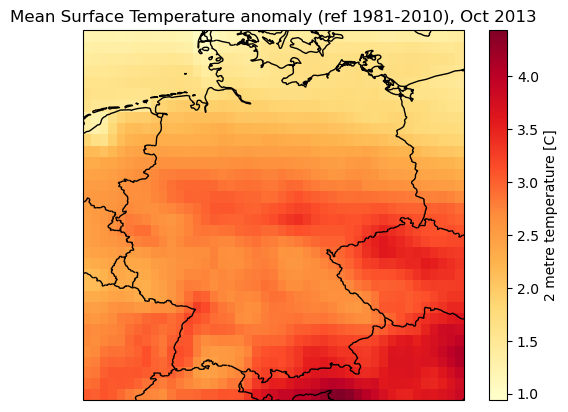

In [25]:
display.map(
    anomaly,
    vmax=None, 
    cmap="YlOrRd", 
    title="Mean Surface Temperature anomaly (ref 1981-2010), Oct 2013"
)

### 1981-2010 climatology vs 2023 montly mean

We now want to compute the 2 metre temperature climatology (montly mean and standard deviation) in Berlin, over the reference period, and compare it with the 2023 monthly means.

We first select the closet data to Berlin:

In [26]:
%%time

t2m_loc = t2m.sel(**LOCATION, method="nearest")
t2m_loc.compute()

CPU times: user 30.7 s, sys: 8.75 s, total: 39.4 s
Wall time: 22.7 s


<xarray.DataArray 't2m' (valid_time: 735600)>
array([-5.899994, -5.399994, -5.649994, ...,       nan,       nan,
             nan], dtype=float32)
Coordinates:
    latitude    float64 52.5
    longitude   float64 13.5
    number      int64 0
    surface     float64 0.0
  * valid_time  (valid_time) datetime64[ns] 1940-01-01 ... 2023-11-30T23:00:00
Attributes: (12/31)
    GRIB_NV:                                  0
    GRIB_Nx:                                  1440
    GRIB_Ny:                                  721
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           t2m
    GRIB_dataType:                            an
    ...                                       ...
    GRIB_typeOfLevel:                         surface
    GRIB_units:                               K
    last_restart_dim_updated:                 735600
    long_name:                                2 metre temperature
    standard_name:                            unknown
    units:                                    C

We then compute the climatology for the reference period 1981-2010:

In [27]:
t2m_climatology_mean = t2m_loc.sel(valid_time=REFERENCE_PERIOD).groupby("valid_time.month").mean(dim="valid_time")
t2m_climatology_std = t2m_loc.sel(valid_time=REFERENCE_PERIOD).groupby("valid_time.month").std(dim="valid_time")

We also compute the  monthly means for the year 2023:

In [28]:
t2m_monthly_mean = t2m_loc.sel(valid_time="2023").resample(valid_time="1M").mean(dim="valid_time")

We finally plot the climatology in Berlin for the reference period against the October 2023 montly means:

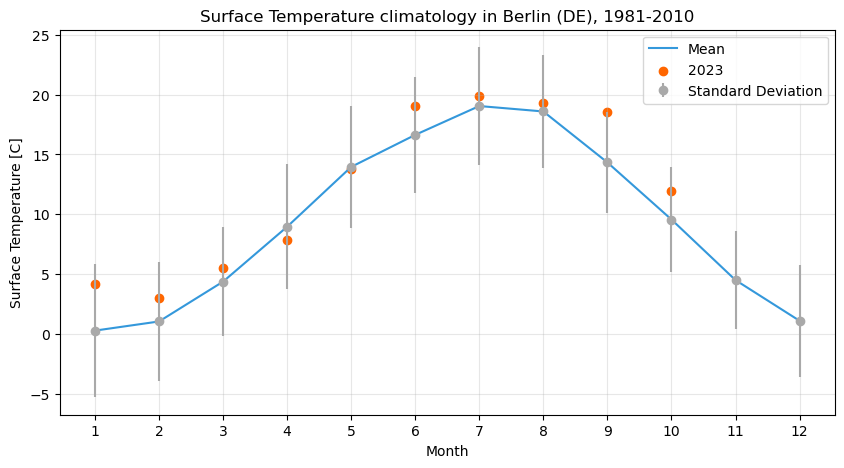

In [29]:
plt.figure(figsize=(10, 5))
t2m_climatology_mean.plot(label="Mean", color="#3498db")
plt.errorbar(
    t2m_climatology_mean.month, 
    t2m_climatology_mean, 
    yerr=t2m_climatology_std, 
    fmt="o", 
    label="Standard Deviation",
    color="#a9a9a9"
)
for month in range (1, 11):
    t2m_point = t2m_monthly_mean.sel(valid_time=t2m_monthly_mean["valid_time.month"]==month)
    label = None
    if month == 1:
        label = "2023"
    plt.scatter(month, t2m_point, color="#ff6600", label=label)
plt.title("Surface Temperature climatology in Berlin (DE), 1981-2010")
plt.xticks(t2m_climatology_mean.month)
plt.xlabel("Month")
plt.ylabel("Surface Temperature [C]")
plt.legend()
plt.grid(alpha=0.3)
plt.show()